# Quantum channel tomography

One can open this notebook in Google Colab (is recommended)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LuchnikovI/QGOpt/blob/master/docs/build/doctrees/nbsphinx/channel_tomography.ipynb)

In this tutorial, we perform quantum channel tomography via Riemannian optimization. First two blocks of code (1. Many-qubit, informationally complete, positive operator-valued measure (IC POVM) and 2. Data set generation (measurement outcomes simulation)) are refered to data generation, third bock dedicated to tomography of a channel. 

First, one needs to import all necessary libraries.

In [1]:
import tensorflow as tf  # tf 2.x
import matplotlib.pyplot as plt
from math import sqrt

try:
    import QGOpt as qgo
except ImportError:
    !pip install git+https://github.com/LuchnikovI/QGOpt
    import QGOpt as qgo

## 1. Many-qubit, informationally complete, positive operator-valued measure (IC POVM)

Before generating measurement outcomes and performing quantum tomography, one needs to introduce POVM describing quantum measurements. For simplicity, we use one-qubit tetrahedral POVM and generalize it on a many-qubit case by taking tensor product between POVM elements, i.e. $\{M_\alpha\}_{\alpha=1}^4$ is the one-qubit tetrahedral POVM, $\{M_{\alpha_1}\otimes \dots \otimes M_{\alpha_N}\}_{\alpha_1=1,\dots,\alpha_N=1}^4$ is the many-qubits tetrahedral POVM.

In [2]:
# Auxiliary function that returns Kronecker product between two
# POVM elements A and B
def kron(A, B):
    """Kronecker product of two POVM elements.

    Args:
        A: complex valued tensor of shape (q, n, k).
        B: complex valued tensor of shape (p, m, l).

    Returns:
        complex valued tensor of shape (q * p, n * m, k * l)"""

    AB = tf.tensordot(A, B, axes=0)
    AB = tf.transpose(AB, (0, 3, 1, 4, 2, 5))
    shape = AB.shape
    AB = tf.reshape(AB, (shape[0] * shape[1],
                         shape[2] * shape[3],
                         shape[4] * shape[5]))
    return AB

# Pauli matrices
sigma_x = tf.constant([[0, 1], [1, 0]], dtype=tf.complex128)
sigma_y = tf.constant([[0 + 0j, -1j], [1j, 0 + 0j]], dtype=tf.complex128)
sigma_z = tf.constant([[1, 0], [0, -1]], dtype=tf.complex128)

# All Pauli matrices in one tensor of shape (3, 2, 2)
sigma = tf.concat([sigma_x[tf.newaxis],
                   sigma_y[tf.newaxis],
                   sigma_z[tf.newaxis]], axis=0)

# Coordinates of thetrahedron peaks (is needed to build tetrahedral POVM)
s0 = tf.constant([0, 0, 1], dtype=tf.complex128)
s1 = tf.constant([2 * sqrt(2) / 3, 0, -1/3], dtype=tf.complex128)
s2 = tf.constant([-sqrt(2) / 3, sqrt(2 / 3), -1 / 3], dtype=tf.complex128)
s3 = tf.constant([-sqrt(2) / 3, -sqrt(2 / 3), -1 / 3], dtype=tf.complex128)

# Coordinates of thetrahedron peaks in one tensor of shape (4, 3)
s = tf.concat([s0[tf.newaxis],
               s1[tf.newaxis],
               s2[tf.newaxis],
               s3[tf.newaxis]], axis=0)

# One qubit thetrahedral POVM
M = 0.25 * (tf.eye(2, dtype=tf.complex128) + tf.tensordot(s, sigma, axes=1))

n = 2  # number of qubits we experiment with

# M for many qubits
Mmq = M
for _ in range(n - 1):
    Mmq = kron(Mmq, M)

## 2. Data set generation (measurement outcomes simulation).

Here we generate a set of measurement outcomes (training set). First of all, we generate a random quantum channel with Kraus rank $k$ by using the quotient manifold of Choi matrices. This quantum channel will be a target unknown one, that we want to reconstruct. Then we generate a set of random pure density matrices, pass them through the generated channel, and simulate measurements of output states. Results of measurements and initial states we write in a data set.

In [3]:
#=================Parameters===================#
num_of_meas = 600000  # number of measurements
k = 2  # Kraus rank (number of Kraus operators)
#==============================================#


# example of quotient manifold of Choi matrices
m = qgo.manifolds.ChoiMatrix()

# random parametrization of Choi matrix of kraus rank k
A = m.random((2 ** (2 * n), k), dtype=tf.complex128)

# corresponding Choi matrix
C = A @ tf.linalg.adjoint(A)

# corresponding quantum channel
C_resh = tf.reshape(C, (2 ** n, 2 ** n, 2 ** n, 2 ** n))
Phi = tf.transpose(C_resh, (1, 3, 0, 2))
Phi = tf.reshape(Phi, (2 ** (2 * n), 2 ** (2 * n)))

# random initial pure density matrices
psi_set = tf.random.normal((num_of_meas, 2 ** n, 2), dtype=tf.float64)
psi_set = qgo.manifolds.real_to_complex(psi_set)
psi_set = psi_set / tf.linalg.norm(psi_set, axis=-1, keepdims=True)
rho_in = psi_set[..., tf.newaxis] * tf.math.conj(psi_set[:, tf.newaxis])

# reshaping density matrices to vectors
rho_in_resh = tf.reshape(rho_in, (-1, 2 ** (2 * n)))

# output states (we pass initial density matrices trough a channel)
rho_out_resh = tf.tensordot(rho_in_resh, Phi, axes=[[1], [1]])
# reshaping output density matrices back to matrix form
rho_out = tf.reshape(rho_out_resh, (-1, 2 ** n, 2 ** n))

# Measurements simulation (by using Gumbel trick for sampling from a
# discrete distribution)
P = tf.cast(tf.einsum('qjk,pkj->pq', Mmq, rho_out), dtype=tf.float64)
eps = tf.random.uniform((num_of_meas, 2 ** (2 * n)), dtype=tf.float64)
eps = -tf.math.log(-tf.math.log(eps))
ind_set = tf.math.argmax(eps + tf.math.log(P), axis=-1)

# projectors that came true
M_set = tf.gather_nd(Mmq, ind_set[:, tf.newaxis])

# resulting dataset
data_set = [rho_in, M_set]

## 3. Data processing (tomography)

First, we define an example of the Choi matrices manifold:

In [4]:
m = qgo.manifolds.ChoiMatrix()

The manifold of Choi matrices is represneted through the quadratic parametrization $C = AA^\dagger$ with qn equivalence relation $A\sim AQ$, where $Q$ is an arbitrary unitary matrix. Thus, we initialize a variable, that represents the parametrization of a Choi matrix:

In [5]:
# random initial paramterization
a = m.random((2 ** (2 * n), 2 ** (2 * n)), dtype=tf.complex128)
# in order to make an optimizer works properly
# one need to turn a to real representation
a = qgo.manifolds.complex_to_real(a)
# variable
a = tf.Variable(a)

Then we initialize Riemannian Adam optimizer:

In [6]:
lr = 0.07  # optimization step size
opt = qgo.optimizers.RAdam(m, lr)

Finally, we ran part of code that calculate forward pass, gradients, and optimization step several times until convergence is reached:

In [7]:
# the list will be filled by value of J distance per iteration
j_distance = []

for _ in range(400):
    with tf.GradientTape() as tape:
        # complex representation of parametrization
        # shape=(2**2n, 2**2n)
        ac = qgo.manifolds.real_to_complex(a)

        # reshape parametrization
        # (2**2n, 2**2n) --> (2**n, 2**n, 2**2n)
        ac = tf.reshape(ac, (2**n, 2**n, 2**(2*n)))

        # Choi tensor (reshaped Choi matrix)
        c = tf.tensordot(ac, tf.math.conj(ac), [[2], [2]])

        # turning Choi tensor to the
        # corresponding quantum channel
        phi = tf.transpose(c, (1, 3, 0, 2))
        phi = tf.reshape(phi, (2**(2*n), 2**(2*n)))

        # reshape initial density
        # matrices to vectors
        rho_resh = tf.reshape(data_set[0], (num_of_meas, 2**(2*n)))

        # passing density matrices
        # through a quantum channel
        rho_out = tf.tensordot(phi,
                            rho_resh,
                            [[1], [1]])
        rho_out = tf.transpose(rho_out)
        rho_out = tf.reshape(rho_out, (num_of_meas, 2**n, 2**n))

        # probabilities of measurement outcomes
        # (povms is a set of POVM elements
        # came true of shape (N, 2**n, 2**n))
        p = tf.linalg.trace(data_set[1] @ rho_out)

        # negative log likelihood (to be minimized)
        L = -tf.reduce_mean(tf.math.log(p))

    # filling j_distance list (for further plotting)
    j_distance.append(tf.reduce_sum(tf.abs(tf.linalg.eigvalsh(tf.reshape(c,
    (2 ** (2 * n), 2 ** (2 * n))) - C))) / (2 * (2 ** n)))
    # gradient
    grad = tape.gradient(L, a)
    # optimization step
    opt.apply_gradients(zip([grad], [a]))

Finally, we plot the dependance between $J$ distance and iteration.

Text(0.5, 0, '$iter$')

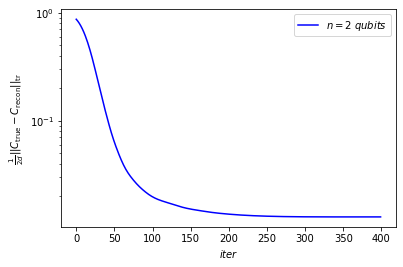

In [14]:
plt.plot(j_distance, 'b')
plt.legend([r'$n=$' + str(n) + r'$\ qubits$'])
plt.yscale('log')
plt.ylabel(r'$\frac{1}{2d}||C_{\rm true} - C_{\rm recon}||_{\rm tr}$')
plt.xlabel(r'$iter$')